### Importing packages:

In [1]:
import os
import torch
import time
import random
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
from model_io import load_model
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error
from data import load_from_path, ReDataset, exact_solution
from model_v2 import Encoder, Decoder, Propagator_concat as Propagator_C, Propagator_encoding as Propagator_E, Model 

### Loading the best models from concat and HDE

In [2]:
concat_best_path = "./FlexiPropagator_2025-02-01-10-28-34_3e9656b5_best.pt"
HDE_best_path = "./FlexiPropagator_2025-02-01-04-31-51_431b6c0b_best.pt"

In [3]:
def get_model(input_dim, latent_dim, Propagator):
    # Instantiate encoder, decoder, and model
    encoder = Encoder(input_dim, latent_dim)
    decoder = Decoder(latent_dim, input_dim)  # Decoder for x(t)
    propagator = Propagator(latent_dim)  # z(t) --> z(t+tau)
    model = Model(encoder, decoder, propagator)
    return model

In [4]:
def load_model_weights(model, checkpoint_path):
    """
    Loads the checkpoint from the given path, extracts the model_state_dict
    (if it exists), and loads it into the model using strict=False.
    """
    if not os.path.isfile(checkpoint_path):
        print(f"Checkpoint file not found at path: {checkpoint_path}")
        return model
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    except Exception as e:
        print(f"Error loading checkpoint from {checkpoint_path}: {e}")
        return model
    
    # If the checkpoint has a key "model_state_dict", extract it.
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

In [5]:
# Instantiate the template models (not used for loading but can serve as a reference)
concat_model_template = get_model(128, 2, Propagator_C)
HDE_model_template    = get_model(128, 2, Propagator_E)

In [6]:
# Loading the best Models:
best_concat_model = get_model(128, 2, Propagator_C)
best_concat_model = load_model_weights(best_concat_model, concat_best_path)

best_HDE_model = get_model(128, 2, Propagator_E)
best_HDE_model = load_model_weights(best_HDE_model, HDE_best_path)

In [7]:
# loading the intervals - 
data_path = "./data"
_, _, re_interval_split, tau_interval_split = load_from_path(data_path)

# Interval Split
print("Re Interval Split", re_interval_split)
print()
print("Tau Interval Split", tau_interval_split)

Re Interval Split IntervalSplit(interpolation=[822.0727212912974, 1022.0727212912974], extrapolation_left=[400, 600.0], extrapolation_right=[2200.0, 2400])

Tau Interval Split IntervalSplit(interpolation=[340.3940583106784, 367.8940583106784], extrapolation_left=[150, 177.5], extrapolation_right=[397.5, 425])


### Model Testing : Concat - HDE

/tmp/ipykernel_4123962/2917382339.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xt = torch.tensor([x_t]).float()[:, None]


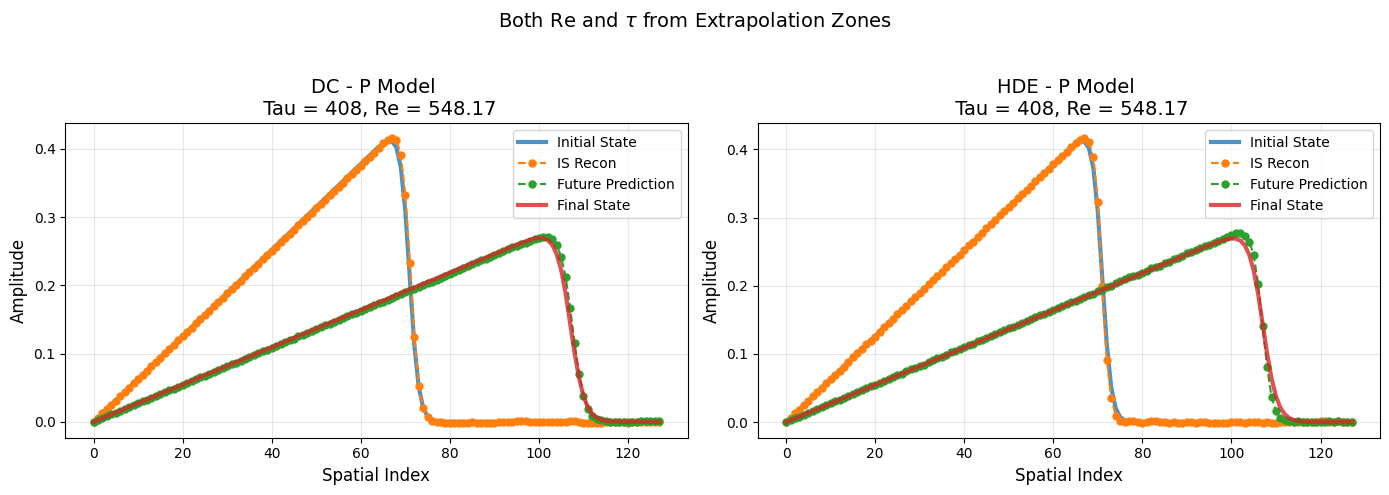

In [8]:
# Choose some Re and Tau in the test combinations
Re_value = np.random.uniform(*re_interval_split.extrapolation_left)  # Randomly selected from R validation zones - in Re

t_0 = 0.25  # Or you can use np.random.uniform(*TRANGE) - don't keep too close to 0
dt = 2.0 / 500.0
tau = np.random.uniform(*tau_interval_split.extrapolation_right)  # In the R Extrap region of tau

x_t = exact_solution(Re_value, t_0)
tau = torch.tensor([tau]).float()[:, None]
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]
t_final = (t_0 + tau * dt).squeeze().item()

x_exact = exact_solution(Re_value, t_final)

# Predictions from both models
with torch.no_grad():
    x_hat_concat, x_hat_tau_concat, _, _, _ = best_concat_model(xt, tau, Re_tensor)
    x_hat_hde, x_hat_tau_hde, _, _, _ = best_HDE_model(xt, tau, Re_tensor)

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plt.suptitle("Both Re and $\\tau$ from Extrapolation Zones", fontsize=14)

# Model Names for Titles
models = ["DC - P Model", "HDE - P Model"]
x_hats = [x_hat_concat, x_hat_hde]
x_hat_taus = [x_hat_tau_concat, x_hat_tau_hde]

for i, ax in enumerate(axes):
    ax.plot(
        xt.squeeze(),
        label="Initial State",
        linewidth=3,
        alpha=0.8,
        color="C0"
    )

    ax.plot(
        x_hats[i].squeeze(),
        label="IS Recon",
        marker='o',
        linestyle='--',
        linewidth=1.5,
        markersize=5,
        color="C1"
    )

    ax.plot(
        x_hat_taus[i].squeeze(),
        label="Future Prediction",
        marker='o',
        linestyle='--',
        linewidth=1.5,
        markersize=5,
        color="C2"
    )

    ax.plot(
        x_exact.squeeze(),
        label="Final State",
        linewidth=3,
        alpha=0.8,
        color="C3"
    )

    ax.set_title(
        f"{models[i]} \n Tau = {int(tau.squeeze().numpy())}, Re = {Re_value:.2f}",
        fontsize=14
    )
    ax.set_xlabel("Spatial Index", fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

#### One result from DC - P Model

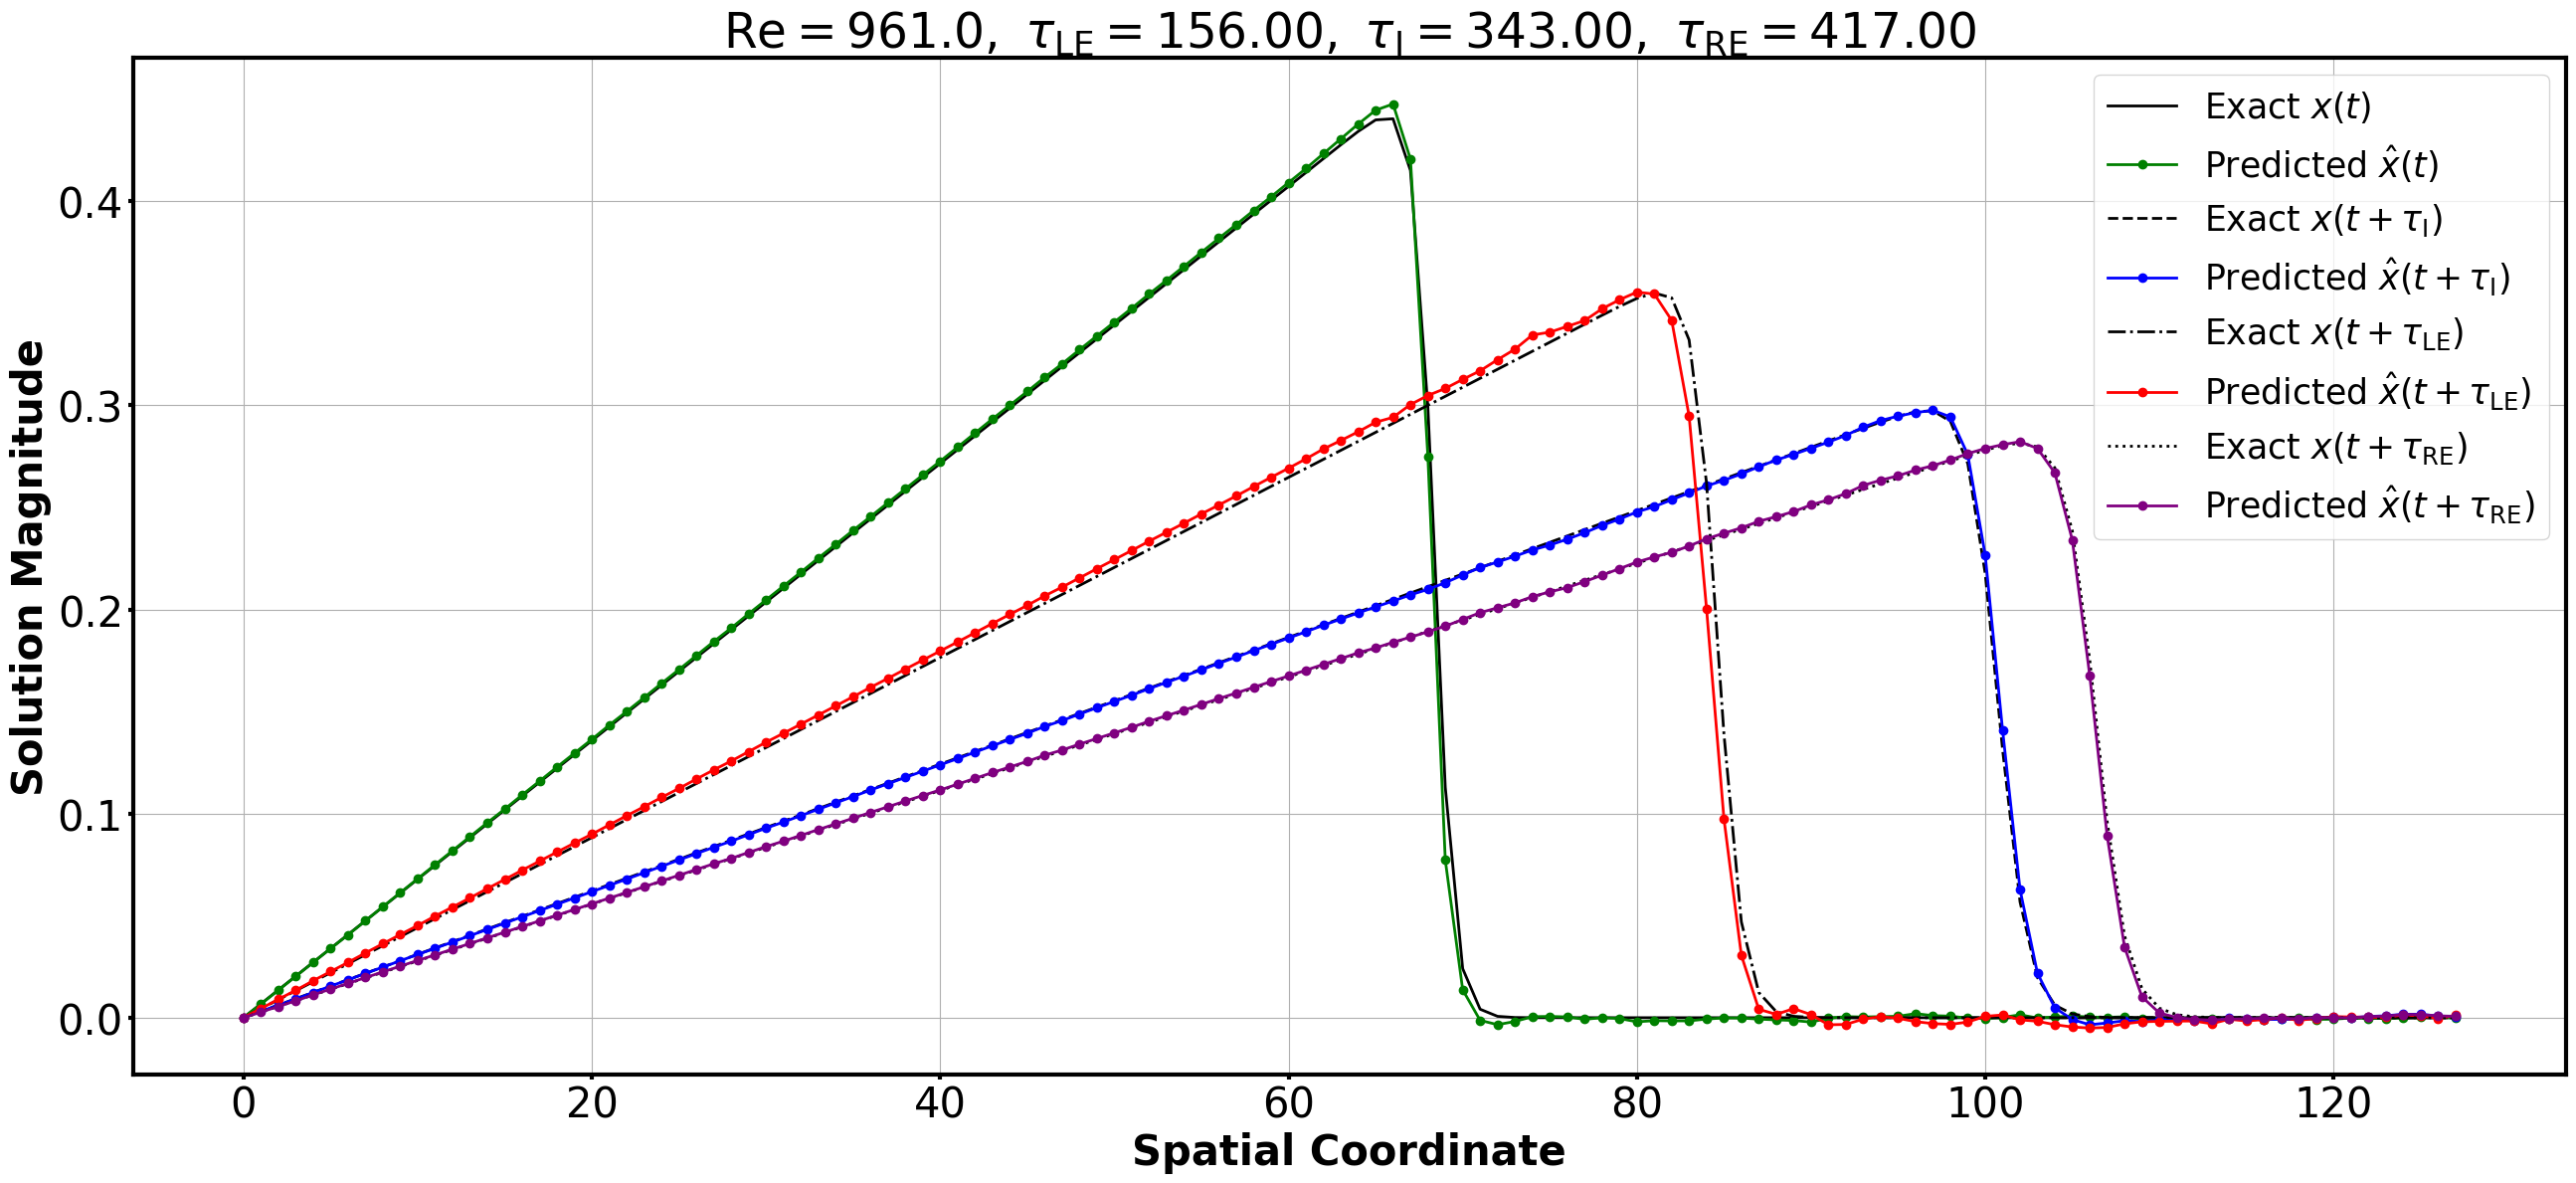

In [9]:
# Generate initial x_t
TRANGE = (0, 2)
Re_range = re_interval_split.interpolation
logRe = np.random.uniform(np.log(Re_range[0]), np.log(Re_range[1]))
Re_value = np.exp(logRe).round().astype(int)
#Re_value = 500  # Some value chosen in the interpolation range
t = 0.16  # Or you can use np.random.uniform(*TRANGE)
dt = 2.0 / 500.0
x_t = exact_solution(Re_value, t)

# Sample tau values for left extrapolation, interpolation, right extrapolation
tau_extrap_left = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_extrap_right = np.random.uniform(*tau_interval_split.extrapolation_right)
tau_interp = np.random.uniform(*tau_interval_split.interpolation)

# Compute exact solutions at t + tau * dt
x_tau_extrap_left, x_tau_extrap_right, x_tau_interp = [
    exact_solution(Re_value, t + T * dt) for T in [tau_extrap_left, tau_extrap_right, tau_interp]
]

# Prepare inputs for the model
tau = torch.tensor([tau_extrap_left, tau_extrap_right, tau_interp]).float()[:, None]
Re_tensor = torch.tensor([Re_value, Re_value, Re_value]).float()[:, None]
xt = torch.tensor([x_t] * 3).float()[:, None]

# Make predictions with the model
with torch.no_grad():
    x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau, Re_tensor)

# Extract predicted x_hat_tau values
x_hat_tau_extrap_left, x_hat_tau_extrap_right, x_hat_tau_interp = x_hat_tau.squeeze().numpy()

# Begin plotting
plt.figure(figsize=(26, 12))
#plt.suptitle("Multiple single shot pred: DC - P Model", fontsize = 32)

# Plot initial state and its reconstruction
plt.plot(x_t, label=r"Exact $x(t)$", color='black', linestyle='-', linewidth=2)
plt.plot(x_hat[0].squeeze().numpy(), label=r"Predicted $\hat{x}(t)$", color='green', marker='o', linewidth=2)

# Plot exact and predicted future states for interpolation
plt.plot(x_tau_interp, label=r"Exact $x(t + \tau_{\mathrm{I}})$", color='black', linestyle='--', linewidth=2)
plt.plot(x_hat_tau_interp, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{I}})$", color='blue', marker='o', linewidth=2)

# Plot exact and predicted future states for left extrapolation
plt.plot(x_tau_extrap_left, label=r"Exact $x(t + \tau_{\mathrm{LE}})$", color='black', linestyle='-.', linewidth=2)
plt.plot(x_hat_tau_extrap_left, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{LE}})$", color='red', marker='o', linewidth=2)

# Plot exact and predicted future states for right extrapolation
plt.plot(x_tau_extrap_right, label=r"Exact $x(t + \tau_{\mathrm{RE}})$", color='black', linestyle=':', linewidth=2)
plt.plot(x_hat_tau_extrap_right, label=r"Predicted $\hat{x}(t + \tau_{\mathrm{RE}})$", color='purple', marker='o', linewidth=2)

# Create the plot title with all tau values using LaTeX formatting
plt.title(
    r"$\mathrm{{Re}} = {:.1f},\ \tau_{{\mathrm{{LE}}}} = {:.2f},\ \tau_{{\mathrm{{I}}}} = {:.2f},\ \tau_{{\mathrm{{RE}}}} = {:.2f}$".format(
        Re_value, int(tau_extrap_left), int(tau_interp), int(tau_extrap_right)
    ),
    fontsize=35
)

plt.xlabel("Spatial Coordinate", fontsize=30, fontweight='bold')
plt.ylabel("Solution Magnitude", fontsize=30, fontweight='bold')

# Adjust axis appearance
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(axis='both', which='major', labelsize=30, width=3)

plt.legend(fontsize=25)
plt.grid(True)
plt.tight_layout()
#plt.savefig("Axis_3_res")
plt.show()

### MSE over all testing regions: DC - P Vs HDE - P

In [10]:
def calculate_mse_with_tracking(re_interval_split, tau_interval_split, exact_solution, dt,
                                best_concat_model, best_HDE_model, n_samples=500):
    """Complete workflow with value tracking"""
    # Initialize value containers
    re_values_val = []
    tau_values_val = []

    # Generate boundary values
    Re_left = np.random.uniform(*re_interval_split.extrapolation_left)
    Re_interp = np.random.uniform(*re_interval_split.interpolation)
    Re_right = np.random.uniform(*re_interval_split.extrapolation_right)

    tau_left = np.random.uniform(*tau_interval_split.extrapolation_left)
    tau_interp = np.random.uniform(*tau_interval_split.interpolation)
    tau_right = np.random.uniform(*tau_interval_split.extrapolation_right)

    # Define all testing combinations
    combinations = [
        (Re_left, tau_left), (Re_left, tau_interp), (Re_left, tau_right),
        (Re_interp, tau_left), (Re_interp, tau_interp), (Re_interp, tau_right),
        (Re_right, tau_left), (Re_right, tau_interp), (Re_right, tau_right)
    ]

    # Results storage
    mse_results_concat = {}
    mse_results_hde = {}
    TRANGE = (0, 2)

    # Main evaluation loop
    for Re_val, tau_val in combinations:
        errors_concat = []
        errors_hde = []
        re_samples = []
        tau_samples = []
        sample_count = 0

        while sample_count < n_samples:
            # Generate sample
            t = np.random.uniform(*TRANGE)
            x_t = exact_solution(Re_val, t)
            x_tau_exact = exact_solution(Re_val, t + tau_val * dt)

            # Model predictions
            tau_tensor = torch.tensor([tau_val]).float().reshape(1, 1)
            Re_tensor = torch.tensor([Re_val]).float().reshape(1, 1)
            x_t_tensor = torch.tensor(x_t).float()[None, None, :]

            # Concatenation model
            with torch.no_grad():
                _, x_hat_tau_concat, _, _, _ = best_concat_model(x_t_tensor, tau_tensor, Re_tensor)
            x_tau_pred_concat = x_hat_tau_concat.squeeze().numpy()

            # HDE model
            with torch.no_grad():
                _, x_hat_tau_hde, _, _, _ = best_HDE_model(x_t_tensor, tau_tensor, Re_tensor)
            x_tau_pred_hde = x_hat_tau_hde.squeeze().numpy()

            # Calculate errors
            error_concat = mean_squared_error(x_tau_exact, x_tau_pred_concat)
            error_hde = mean_squared_error(x_tau_exact, x_tau_pred_hde)

            # Store results
            errors_concat.append(error_concat)
            errors_hde.append(error_hde)
            re_samples.append(Re_val)
            tau_samples.append(tau_val)
            sample_count += 1

        # Update global value lists
        re_values_val.extend(re_samples)
        tau_values_val.extend(tau_samples)

        # Store average MSE
        Re_label = 'left' if Re_val == Re_left else 'interp' if Re_val == Re_interp else 'right'
        tau_label = 'left' if tau_val == tau_left else 'interp' if tau_val == tau_interp else 'right'
        
        mse_results_concat[f"Re_{Re_label}-tau_{tau_label}"] = np.mean(errors_concat)
        mse_results_hde[f"Re_{Re_label}-tau_{tau_label}"] = np.mean(errors_hde)

    # Print results
    print("MSE Results for Concatenation Model:")
    for label, mse in mse_results_concat.items():
        print(f"{label}: {mse:.4e}")

    print("\nMSE Results for HDE Model:")
    for label, mse in mse_results_hde.items():
        print(f"{label}: {mse:.4e}")

    return re_values_val, tau_values_val, mse_results_concat, mse_results_hde


re_vals, tau_vals, mse_concat, mse_hde = calculate_mse_with_tracking(
    re_interval_split,
    tau_interval_split,
    exact_solution,
    dt,
    best_concat_model,
    best_HDE_model,
    n_samples = 100
)

MSE Results for Concatenation Model:
Re_left-tau_left: 8.2102e-05
Re_left-tau_interp: 3.7492e-05
Re_left-tau_right: 2.4260e-05
Re_interp-tau_left: 6.0852e-05
Re_interp-tau_interp: 2.9476e-06
Re_interp-tau_right: 5.9520e-06
Re_right-tau_left: 1.5478e-04
Re_right-tau_interp: 7.2859e-06
Re_right-tau_right: 5.5746e-06

MSE Results for HDE Model:
Re_left-tau_left: 1.4591e-04
Re_left-tau_interp: 1.8865e-04
Re_left-tau_right: 1.9435e-04
Re_interp-tau_left: 1.2449e-04
Re_interp-tau_interp: 7.8842e-06
Re_interp-tau_right: 4.2467e-06
Re_right-tau_left: 2.1957e-03
Re_right-tau_interp: 1.4276e-03
Re_right-tau_right: 1.3174e-03


In [11]:
def plot_alpha_tau_scatter(alpha_values,
                           tau_values,
                           alpha_interval_split,
                           tau_interval_split,
                           mse_dict=None,
                           figsize=(13, 7),
                           point_size=5,
                           point_alpha=0.2,
                           color_alpha=0.5):
    """
    Plots a scatter of (alpha, tau) with regions colored by MSE if provided.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Add colored regions first if MSE data is provided
    if mse_dict is not None:
        mse_values = list(mse_dict.values())
        norm = plt.Normalize(vmin=min(mse_values), vmax=max(mse_values))
        cmap = plt.cm.viridis

        interval_parts = ['left', 'interp', 'right']
        
        for re_part in interval_parts:
            # Get alpha (Re) boundaries
            if re_part == 'left':
                a_min, a_max = alpha_interval_split.extrapolation_left
            elif re_part == 'interp':
                a_min, a_max = alpha_interval_split.interpolation
            else:
                a_min, a_max = alpha_interval_split.extrapolation_right

            for tau_part in interval_parts:
                # Get tau boundaries
                if tau_part == 'left':
                    t_min, t_max = tau_interval_split.extrapolation_left
                elif tau_part == 'interp':
                    t_min, t_max = tau_interval_split.interpolation
                else:
                    t_min, t_max = tau_interval_split.extrapolation_right

                # Get corresponding MSE
                key = f"Re_{re_part}-tau_{tau_part}"
                if (mse := mse_dict.get(key)) is None:
                    continue
                
                # Create colored rectangle
                rect = patches.Rectangle(
                    (a_min, t_min), a_max - a_min, t_max - t_min,
                    facecolor=cmap(norm(mse)), alpha=color_alpha, edgecolor='none'
                )
                ax.add_patch(rect)

        # Add colorbar
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='MSE')

    # Main scatter plot
    ax.scatter(alpha_values, tau_values, s=point_size, alpha=point_alpha)
    ax.set_xlabel('Re')
    ax.set_ylabel('Tau')
    ax.set_title('MSE Validation zones')

    # Get interval boundaries
    a_left_lo, a_left_hi = alpha_interval_split.extrapolation_left
    a_int_lo, a_int_hi = alpha_interval_split.interpolation
    a_right_lo, a_right_hi = alpha_interval_split.extrapolation_right

    t_left_lo, t_left_hi = tau_interval_split.extrapolation_left
    t_int_lo, t_int_hi = tau_interval_split.interpolation
    t_right_lo, t_right_hi = tau_interval_split.extrapolation_right

    # Set axis limits with padding
    alpha_min, alpha_max = a_left_lo, a_right_hi
    tau_min, tau_max = t_left_lo, t_right_hi
    alpha_pad = 0.05 * (alpha_max - alpha_min)
    tau_pad = 0.075 * (tau_max - tau_min)
    ax.set_xlim(alpha_min - alpha_pad - 0.075, alpha_max + alpha_pad + 0.075)
    ax.set_ylim(tau_min - tau_pad - 10, tau_max + tau_pad + 10)

    # Bounding rectangle
    bounding_rect = patches.Rectangle(
        (alpha_min, tau_min),
        alpha_max - alpha_min,
        tau_max - tau_min,
        fill=False, edgecolor='red', linewidth=3
    )
    ax.add_patch(bounding_rect)

    # Bounding box labels
    ax.text((alpha_min + alpha_max)/2, tau_min - 0.02*(tau_max - tau_min),
            f"tau = {tau_min}", color='red', ha='center', va='top')
    ax.text((alpha_min + alpha_max)/2, tau_max + 0.02*(tau_max - tau_min),
            f"tau = {tau_max}", color='red', ha='center', va='bottom')
    ax.text(alpha_min - 0.008*(alpha_max - alpha_min), (tau_min + tau_max)/2,
            f"Re = {alpha_min}", color='red', ha='right', va='center', rotation=90)
    ax.text(alpha_max + 0.008*(alpha_max - alpha_min), (tau_min + tau_max)/2,
            f"Re = {alpha_max}", color='red', ha='left', va='center', rotation=90)

    # Vertical dashed lines
    alpha_boundaries = sorted([a_left_lo, a_left_hi, a_int_lo, a_int_hi, a_right_lo, a_right_hi])
    for a_line in alpha_boundaries:
        if alpha_min < a_line < alpha_max:
            ax.axvline(a_line, color='black', linestyle='--', linewidth=1.5)
            ax.text(a_line + 0.001*(alpha_max - alpha_min), 
                    ax.get_ylim()[1] - 0.02*(ax.get_ylim()[1] - tau_min),
                    f"{a_line:.4f}", rotation=90, ha='left', va='top')

    # Horizontal dashed lines
    tau_boundaries = sorted([t_left_lo, t_left_hi, t_int_lo, t_int_hi, t_right_lo, t_right_hi])
    for t_line in tau_boundaries:
        if tau_min < t_line < tau_max:
            ax.axhline(t_line, color='black', linestyle='--', linewidth=1.5)
            ax.text(ax.get_xlim()[1] - 0.03*(ax.get_xlim()[1] - alpha_min),
                    t_line + 1.5, f"{t_line:.1f}", ha='right', va='bottom')

    plt.show()

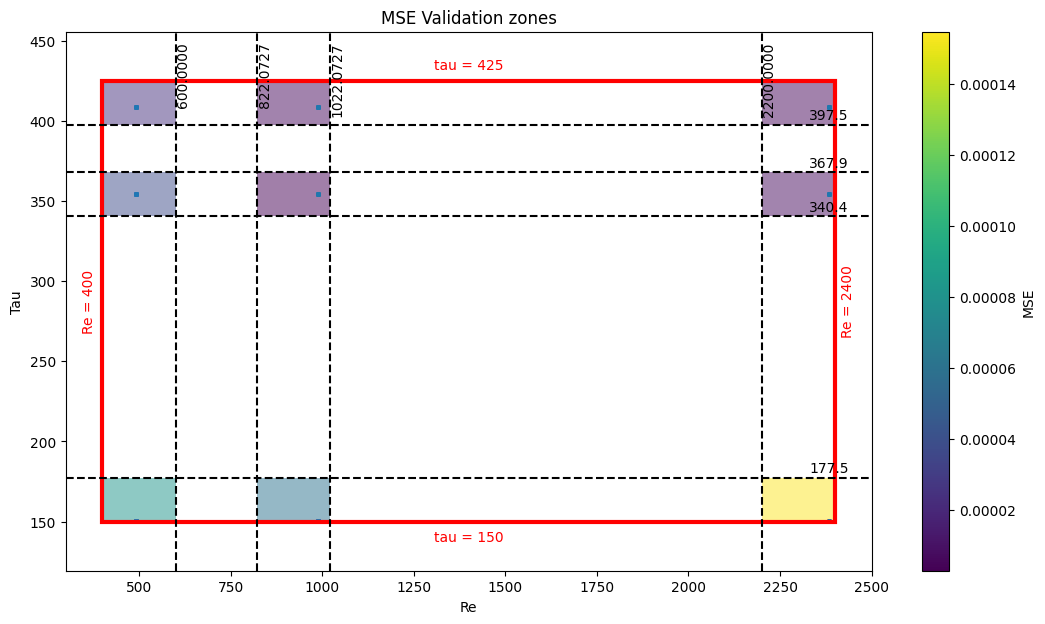

In [12]:
# For concatenation model results
from matplotlib import patches
plot_alpha_tau_scatter(
    re_vals,
    tau_vals,
    re_interval_split,
    tau_interval_split,
    mse_dict=mse_concat
)

## AE LSTM Model

In [13]:
from LSTM_model import AE_Encoder, AE_Decoder, AE_Model, PytorchLSTM, measure_lstm_prediction_time, collect_snapshots 
from LSTM_model import collect_multiparam_snapshots_train, collect_multiparam_snapshots_test, exact_solution

Final time is: 2.06000018119812
Shapes: torch.Size([1, 1]) torch.Size([1, 1]) torch.Size([1, 1, 128])
Predicted Shapes: torch.Size([1, 1, 128]) torch.Size([1, 1, 128])
Elapsed Time: 0.004642 seconds


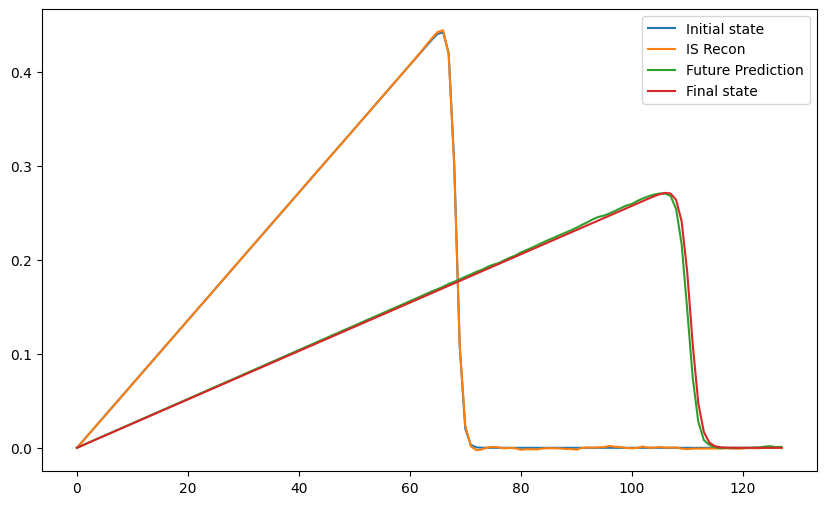

In [14]:
# Define parameters
Re_value = 1020
t_0 = 0.16  # Or use np.random.uniform(*TRANGE)
dt = 2.0 / 500.0
tau = 475

# Generate initial condition and target final state
x_t = exact_solution(Re_value, t_0)
tau = torch.tensor([tau], dtype=torch.float32)[:, None]
Re_tensor = torch.tensor([Re_value], dtype=torch.float32)[:, None]
xt = torch.tensor([x_t], dtype=torch.float32)[:, None]
t_final = (t_0 + tau * dt).squeeze().item()

print("Final time is:", t_final)
print("Shapes:", tau.shape, Re_tensor.shape, xt.shape)

x_exact = exact_solution(Re_value, t_final)

# Ensure model is in evaluation mode
best_concat_model.eval()

# Move tensors to same device as model
device = next(best_concat_model.parameters()).device
xt, tau, Re_tensor = xt.to(device), tau.to(device), Re_tensor.to(device)

# Synchronize before timing (if using GPU)
if torch.cuda.is_available():
    torch.cuda.synchronize()

start_time = time.time()

# Perform inference
with torch.no_grad():
    x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau, Re_tensor)

# Synchronize after timing (if using GPU)
if torch.cuda.is_available():
    torch.cuda.synchronize()

end_time = time.time()
lapsed = end_time - start_time

print("Predicted Shapes:", x_hat.shape, x_hat_tau.shape)
print("Elapsed Time: {:.6f} seconds".format(lapsed))

# Move tensors to CPU for plotting
xt_cpu = xt.squeeze().cpu().numpy()
x_hat_cpu = x_hat.squeeze().cpu().numpy()
x_hat_tau_cpu = x_hat_tau.squeeze().cpu().numpy()
x_exact_cpu = x_exact.squeeze()  # Assuming this is already a NumPy array

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(xt_cpu, label="Initial state")
plt.plot(x_hat_cpu, label="IS Recon")
plt.plot(x_hat_tau_cpu, label="Future Prediction")
plt.plot(x_exact_cpu, label="Final state")
plt.legend()
plt.show()

### Loading the AE and LSTM model

In [15]:
# Loading the model weights: Model, Decoder, LSTM
ae_encoder_path = "./LSTM_model/ae_encoder_weights.pth"
ae_decoder_path = "./LSTM_model/ae_decoder_weights.pth"
ae_model_path = "./LSTM_model/ae_model.pth"
lstm_path = "./LSTM_model/lstm_weights.pth"

In [16]:
# Define the same architectures
AE_encoder = AE_Encoder(input_dim=128) 
AE_decoder = AE_Decoder(latent_dim=2, output_dim=128) 
ae_model = AE_Model(AE_encoder, AE_decoder) 
lstm_model = PytorchLSTM() 

# Load the saved weights
AE_encoder.load_state_dict(torch.load(ae_encoder_path))
AE_decoder.load_state_dict(torch.load(ae_decoder_path))
ae_model.load_state_dict(torch.load(ae_model_path))
lstm_model.load_state_dict(torch.load(lstm_path))

# Set models to evaluation mode if needed
AE_encoder.eval()
AE_decoder.eval()
ae_model.eval()
lstm_model.eval()

print("Model weights loaded successfully.")

Model weights loaded successfully.


In [17]:
for name, param in ae_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: encoder._net.0.weight | Device: cpu
Layer: encoder._net.0.bias | Device: cpu
Layer: encoder._net.2.weight | Device: cpu
Layer: encoder._net.2.bias | Device: cpu
Layer: encoder._net.4.weight | Device: cpu
Layer: encoder._net.4.bias | Device: cpu
Layer: encoder._net.6.weight | Device: cpu
Layer: encoder._net.6.bias | Device: cpu
Layer: encoder._net.8.weight | Device: cpu
Layer: encoder._net.8.bias | Device: cpu
Layer: encoder._net.10.weight | Device: cpu
Layer: encoder._net.10.bias | Device: cpu
Layer: decoder._net.0.weight | Device: cpu
Layer: decoder._net.0.bias | Device: cpu
Layer: decoder._net.2.weight | Device: cpu
Layer: decoder._net.2.bias | Device: cpu
Layer: decoder._net.4.weight | Device: cpu
Layer: decoder._net.4.bias | Device: cpu
Layer: decoder._net.6.weight | Device: cpu
Layer: decoder._net.6.bias | Device: cpu
Layer: decoder._net.8.weight | Device: cpu
Layer: decoder._net.8.bias | Device: cpu
Layer: decoder._net.10.weight | Device: cpu
Layer: decoder._net.10.bias | 

In [18]:
for name, param in lstm_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: lstm1.weight_ih_l0 | Device: cpu
Layer: lstm1.weight_hh_l0 | Device: cpu
Layer: lstm1.bias_ih_l0 | Device: cpu
Layer: lstm1.bias_hh_l0 | Device: cpu
Layer: lstm2.weight_ih_l0 | Device: cpu
Layer: lstm2.weight_hh_l0 | Device: cpu
Layer: lstm2.bias_ih_l0 | Device: cpu
Layer: lstm2.bias_hh_l0 | Device: cpu
Layer: fc.weight | Device: cpu
Layer: fc.bias | Device: cpu


In [19]:
output_seq_pred_train = "./LSTM_model/output_seq_pred_train.npy"
output_seq_train = "./LSTM_model/output_seq_train.npy"
lstm_testing_data = "./LSTM_model/lstm_testing_data.npy"

output_seq_pred_train = np.load(output_seq_pred_train)
output_seq_train = np.load(output_seq_train)
lstm_testing_data = np.load(lstm_testing_data)

print(output_seq_pred_train.shape, output_seq_train.shape, lstm_testing_data.shape)

(25760, 2) (25760, 2) (5, 500, 3)


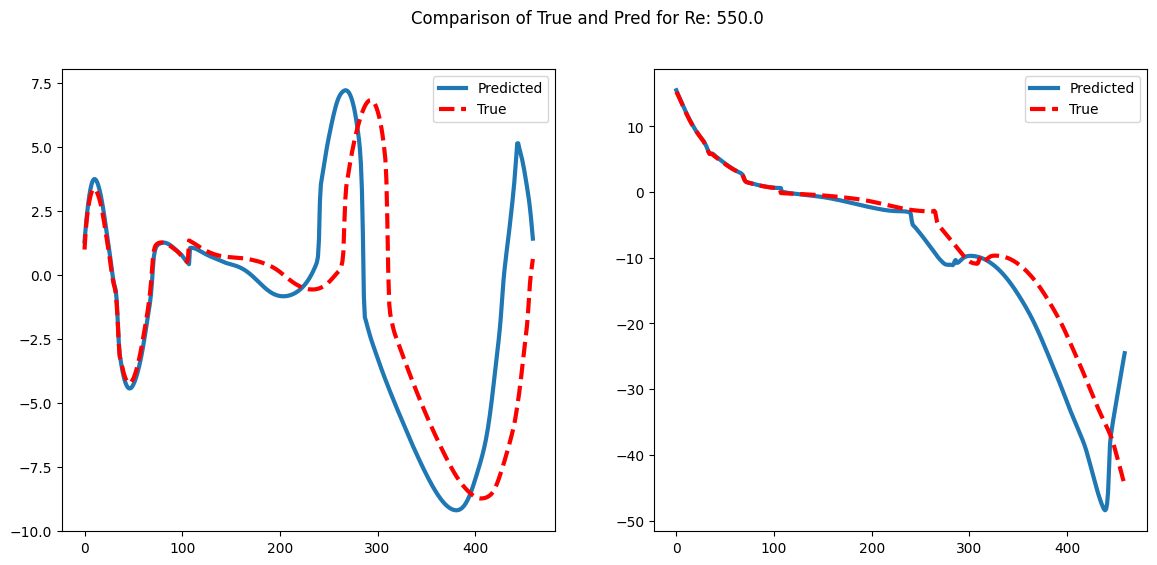

In [20]:
# Prediction of evolution of LS by the LSTM Model for test Re
num_test_snapshots, num_time_steps, _ = lstm_testing_data.shape

sim_num = 0
time_window = 40
num_time_steps = 500

# We'll do 90 predictions after the initial 10
samples_to_predict = num_time_steps - time_window  # 90

# ---------------------------
# 2) Prepare a rolling buffer & arrays to store predictions
# ---------------------------
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((samples_to_predict, 2), dtype=np.float32)
y_true = np.zeros((samples_to_predict, 2), dtype=np.float32)

# Initialize the first 10 steps from the data
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

# ---------------------------
# 3) Autoregressive loop
# ---------------------------
sample = 0
lstm_model.eval()

with torch.no_grad():
    for t in range(time_window, num_time_steps):  # from 10..99
        # Convert to PyTorch tensor
        inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
        
        # Forward pass
        pred = lstm_model(inp_tensor)               # shape [1, 2]
        pred_np = pred.numpy()[0, :]           # shape [2,]
        
        # Store prediction & ground truth
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]  # Fix here
        
        # Shift the rolling window by 1
        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np
        
        sample += 1

# ---------------------------
# 4) Plot predictions vs. ground truth
# ---------------------------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the first latent dimension
ax[0].plot(predictions[:, 0], label='Predicted', linewidth=3)
ax[0].plot(lstm_testing_data[sim_num, time_window:, 0], 'r--', label='True', linewidth=3)
ax[0].legend()

# Plot the second latent dimension
ax[1].plot(predictions[:, 1], label='Predicted', linewidth=3)
ax[1].plot(lstm_testing_data[sim_num, time_window:, 1], 'r--', label='True', linewidth=3)
ax[1].legend()

r_num = (np.unique(lstm_testing_data[sim_num, time_window:, 2])*1000).squeeze()
plt.suptitle(f"Comparison of True and Pred for Re: {r_num}")
plt.show()


In [21]:
sim_num = 0
final_time = 475  # predict the 480th latent
elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(AE_decoder, lstm_model, lstm_testing_data, sim_num, final_time, time_window=40)

print(f"Time to predict up to t={final_time}: {elapsed_sec:.4f} s")
print("Predicted latent at final_time:", pred_latent)
print("True latent at final_time:", true_latent)

Time to predict up to t=475: 0.2422 s
Predicted latent at final_time: [  1.4871125 -46.88186  ]
True latent at final_time: [ -6.60006714 -33.96752548]


In [22]:
num_time_steps = 500
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=num_time_steps)
dt = 2.0/np.shape(tsteps)[0]
time_window = 40 # The window size of the LSTM

snapshots_train, rnum_vals_train = collect_multiparam_snapshots_train() # So that dim=0 corresponds to number of snapshots
snapshots_test, rnum_vals_test = collect_multiparam_snapshots_test() # So that dim=0 corresponds to number of snapshots
rnum_vals_test*1000

array([ 550., 1025., 1500., 1975., 2450.])

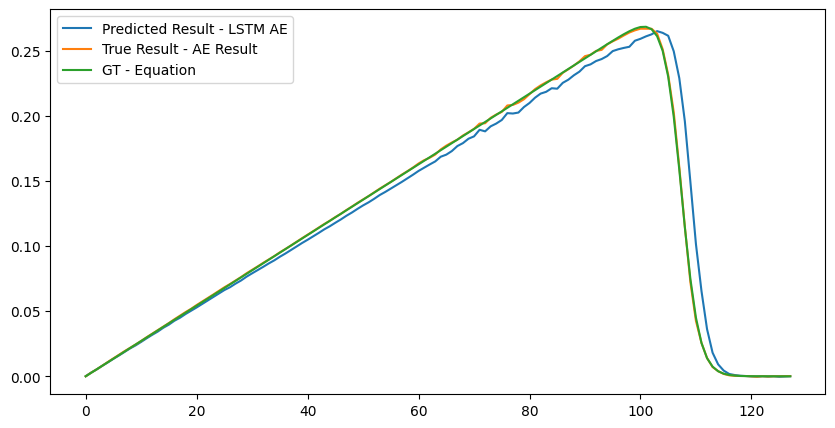

In [23]:
# Passing the latent into the decoder:

x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype = torch.float32))
x_hat_tau = AE_decoder(torch.tensor(true_latent, dtype = torch.float32))
exact = exact_solution(rnum_vals_test[sim_num]*1000, final_time*dt)

plt.figure(figsize = (10, 5))
plt.plot(x_hat_tau_pred.cpu().detach().numpy(), label = "Predicted Result - LSTM AE")
plt.plot(x_hat_tau.cpu().detach().numpy(), label = "True Result - AE Result")
plt.plot(exact, label = "GT - Equation")

plt.legend();

## Accuracy Comparison

In [24]:
for name, param in best_concat_model.named_parameters():
    print(f"Layer: {name} | Device: {param.device}")

Layer: encoder._net.0.weight | Device: cpu
Layer: encoder._net.0.bias | Device: cpu
Layer: encoder._net.2.norm.weight | Device: cpu
Layer: encoder._net.2.norm.bias | Device: cpu
Layer: encoder._net.3.weight | Device: cpu
Layer: encoder._net.3.bias | Device: cpu
Layer: encoder._net.5.norm.weight | Device: cpu
Layer: encoder._net.5.norm.bias | Device: cpu
Layer: encoder._net.6.weight | Device: cpu
Layer: encoder._net.6.bias | Device: cpu
Layer: encoder._net.8.norm.weight | Device: cpu
Layer: encoder._net.8.norm.bias | Device: cpu
Layer: encoder._net.9.weight | Device: cpu
Layer: encoder._net.9.bias | Device: cpu
Layer: encoder._net.11.norm.weight | Device: cpu
Layer: encoder._net.11.norm.bias | Device: cpu
Layer: encoder._net.12.weight | Device: cpu
Layer: encoder._net.12.bias | Device: cpu
Layer: encoder._net.14.norm.weight | Device: cpu
Layer: encoder._net.14.norm.bias | Device: cpu
Layer: encoder._net.15.weight | Device: cpu
Layer: encoder._net.15.bias | Device: cpu
Layer: decoder._ne

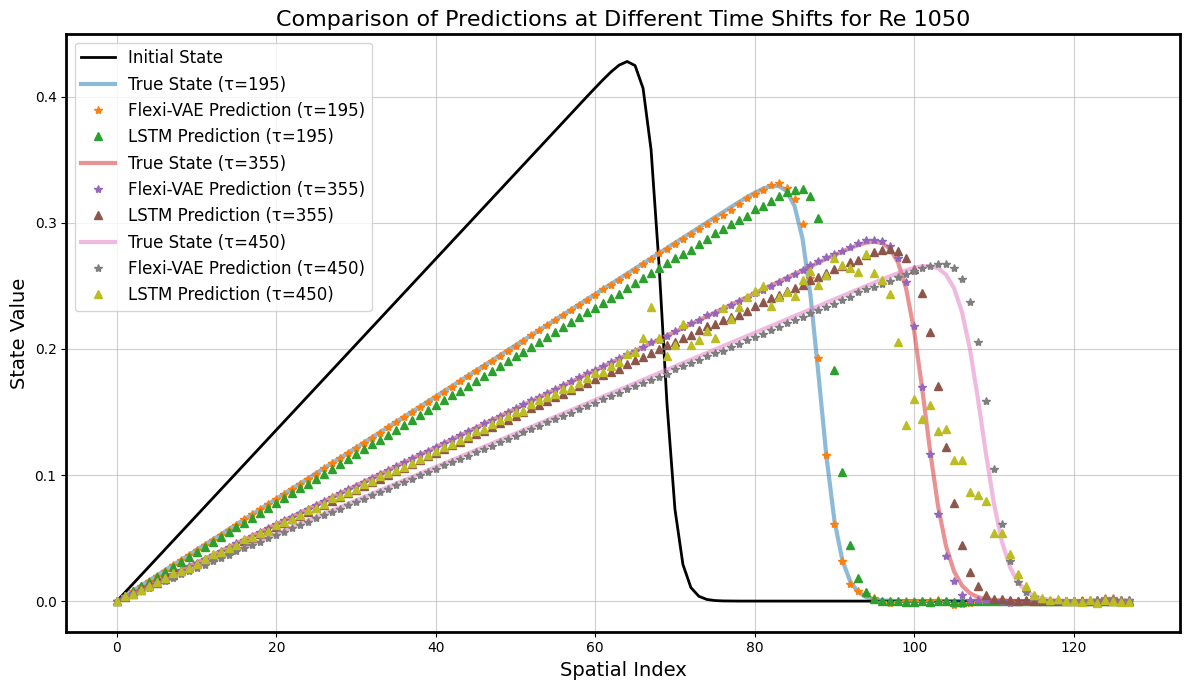

In [25]:
# Simulation setup
sim_num = 0

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time - keep this fixed; Corrosponds to window size of 40!
dt = 2.0 / 500.0
taus = [195, 355, 450]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

# Initialize plot
plt.figure(figsize=(12, 7))

# Set axis thickness
plt.rc('axes', linewidth=2)

# Plot the initial state
plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", label="Initial State")

for tau in taus:
    # Calculate final time
    t_final = t_0 + tau * dt
    x_exact = exact_solution(Re_value, t_final)

    # Flexi-VAE Prediction
    tau_tensor = torch.tensor([tau]).float()[:, None]
    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

    # LSTM Model Prediction
    time_shift_in_lstm = int(tau + t_0 / dt)
    elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
        AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
    )
    x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

    # Plot ground truth
    plt.plot(
        x_exact, linewidth=3, linestyle="-", alpha = 0.5, label=f"True State (τ={tau})"
    )

    # Plot Flexi-VAE prediction
    plt.plot(
        x_hat_tau.detach().squeeze().numpy(),
        '*',
        markersize=6,
        label=f"Flexi-VAE Prediction (τ={tau})"
    )

    # Plot LSTM prediction
    plt.plot(
        x_hat_tau_pred.cpu().detach().numpy(),
        '^',
        markersize=6,
        label=f"LSTM Prediction (τ={tau})"
    )

# Add legend and labels
plt.xlabel("Spatial Index", fontsize=14)
plt.ylabel("State Value", fontsize=14)
plt.title("Comparison of Predictions at Different Time Shifts for Re 1050", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()


# Save the figure
#plt.savefig("comparison_predictions_tau_re_1050.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


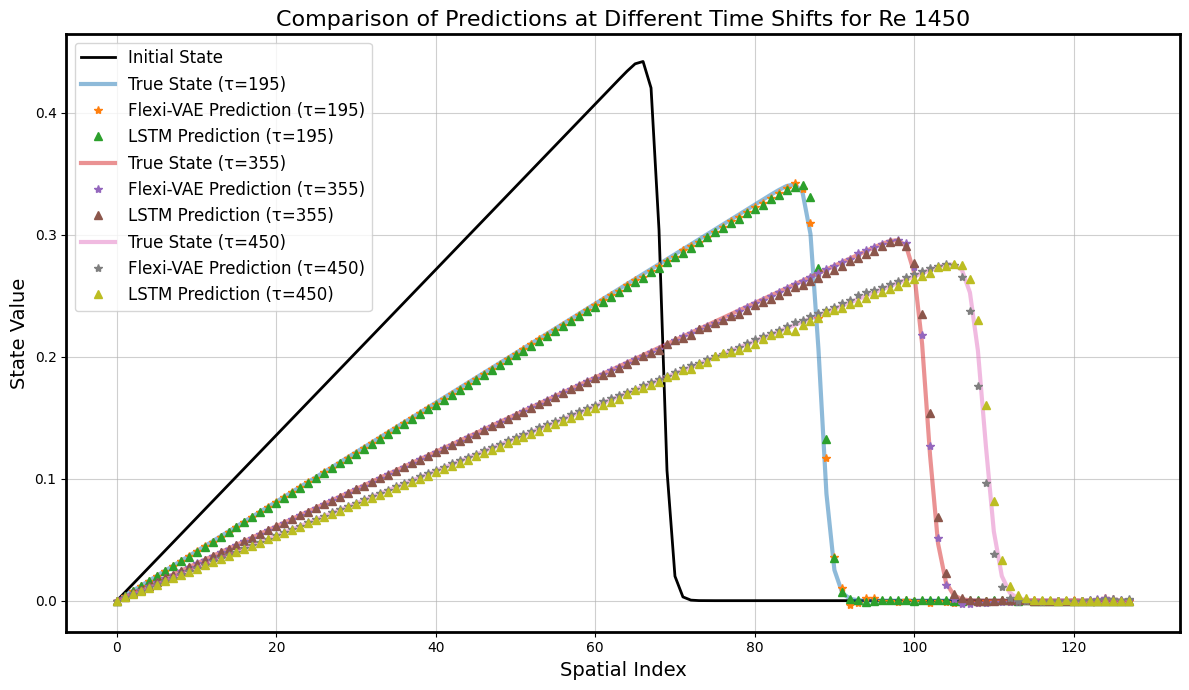

In [26]:
# Simulation setup
sim_num = 1

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0
taus = [195, 355, 450]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

# Initialize plot
plt.figure(figsize=(12, 7))

# Set axis thickness
plt.rc('axes', linewidth=2)

# Plot the initial state
plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", label="Initial State")

for tau in taus:
    # Calculate final time
    t_final = t_0 + tau * dt
    x_exact = exact_solution(Re_value, t_final)

    # Flexi-VAE Prediction
    tau_tensor = torch.tensor([tau]).float()[:, None]
    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

    # LSTM Model Prediction
    time_shift_in_lstm = int(tau + t_0 / dt)
    elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
        AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
    )
    x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

    # Plot ground truth
    plt.plot(
        x_exact, linewidth=3, linestyle="-", alpha = 0.5, label=f"True State (τ={tau})"
    )

    # Plot Flexi-VAE prediction
    plt.plot(
        x_hat_tau.detach().squeeze().numpy(),
        '*',
        markersize=6,
        label=f"Flexi-VAE Prediction (τ={tau})"
    )

    # Plot LSTM prediction
    plt.plot(
        x_hat_tau_pred.cpu().detach().numpy(),
        '^',
        markersize=6,
        label=f"LSTM Prediction (τ={tau})"
    )

# Add legend and labels
plt.xlabel("Spatial Index", fontsize=14)
plt.ylabel("State Value", fontsize=14)
plt.title("Comparison of Predictions at Different Time Shifts for Re 1450", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()


# Save the figure
#plt.savefig("comparison_predictions_tau_re_1450.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


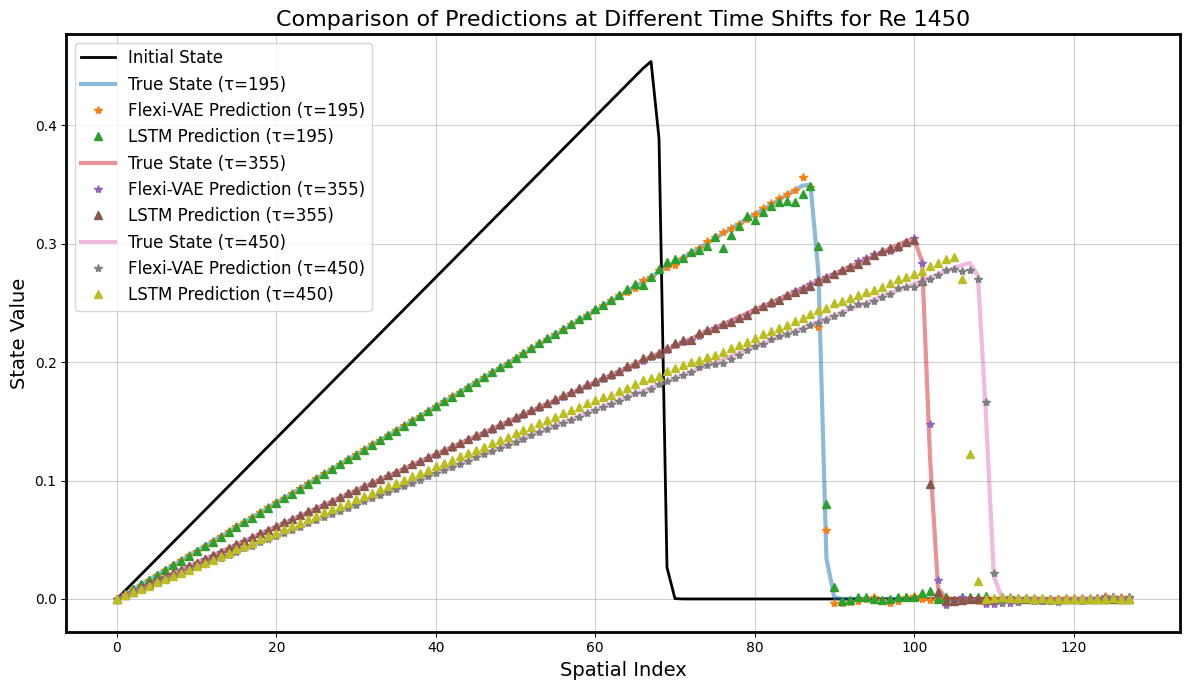

In [27]:
# Simulation setup
sim_num = -1

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0
taus = [195, 355, 450]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

# Initialize plot
plt.figure(figsize=(12, 7))

# Set axis thickness
plt.rc('axes', linewidth=2)

# Plot the initial state
plt.plot(xt.squeeze().numpy(), linewidth=2, color="black", label="Initial State")

for tau in taus:
    # Calculate final time
    t_final = t_0 + tau * dt
    x_exact = exact_solution(Re_value, t_final)

    # Flexi-VAE Prediction
    tau_tensor = torch.tensor([tau]).float()[:, None]
    with torch.no_grad():
        x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, tau_tensor, Re_tensor)

    # LSTM Model Prediction
    time_shift_in_lstm = int(tau + t_0 / dt)
    elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
        AE_decoder, lstm_model, lstm_testing_data, sim_num, time_shift_in_lstm, time_window=40
    )
    x_hat_tau_pred = AE_decoder(torch.tensor(pred_latent, dtype=torch.float32))

    # Plot ground truth
    plt.plot(
        x_exact, linewidth=3, linestyle="-", alpha = 0.5, label=f"True State (τ={tau})"
    )

    # Plot Flexi-VAE prediction
    plt.plot(
        x_hat_tau.detach().squeeze().numpy(),
        '*',
        markersize=6,
        label=f"Flexi-VAE Prediction (τ={tau})"
    )

    # Plot LSTM prediction
    plt.plot(
        x_hat_tau_pred.cpu().detach().numpy(),
        '^',
        markersize=6,
        label=f"LSTM Prediction (τ={tau})"
    )

# Add legend and labels
plt.xlabel("Spatial Index", fontsize=14)
plt.ylabel("State Value", fontsize=14)
plt.title("Comparison of Predictions at Different Time Shifts for Re 1450", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()


# Save the figure
#plt.savefig("comparison_predictions_tau_re_1450.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Temporal Comparison

In [28]:
sim_num = 0

re_1 = rnum_vals_test[sim_num]
Re_value = re_1 * 1000
t_0 = 0.16  # Initial time
dt = 2.0 / 500.0
taus = [195, 355, 450]  # Time shifts for analysis

# Initial state
x_t = exact_solution(Re_value, t_0)
Re_tensor = torch.tensor([Re_value]).float()[:, None]
xt = torch.tensor([x_t]).float()[:, None]

taus = [175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450] 
vae_times = []  # Times for Flexi VAE
lstm_times = []  # Average times for LSTM
lstm_variability = []  # Variability (e.g., standard deviation)

# Run multiple trials for variability in LSTM
for tau in taus:
    vae_time = []
    lstm_time = []
    for _ in tqdm(range(200), desc = f"Progress for tau: {tau}"):  # Repeat for variability # It will TAKE TIME if value is high!
        # Flexi VAE prediction
        start_time = time.time()
        with torch.no_grad():
            x_hat, x_hat_tau, mean, log_var, z_tau = best_concat_model(xt, torch.tensor([[tau]]).float(), Re_tensor)
        vae_time.append(time.time() - start_time)

        # LSTM prediction
        elapsed_sec, _, _ = measure_lstm_prediction_time(AE_decoder, lstm_model, lstm_testing_data, sim_num, tau + int(t_0/dt), time_window=40)
        lstm_time.append(elapsed_sec)

    vae_times.append(np.mean(vae_time))
    lstm_times.append(np.mean(lstm_time))
    lstm_variability.append(np.std(lstm_time))

Progress for tau: 450: 100%|██████████████████████████████████████████████| 200/200 [00:47<00:00,  4.22it/s]


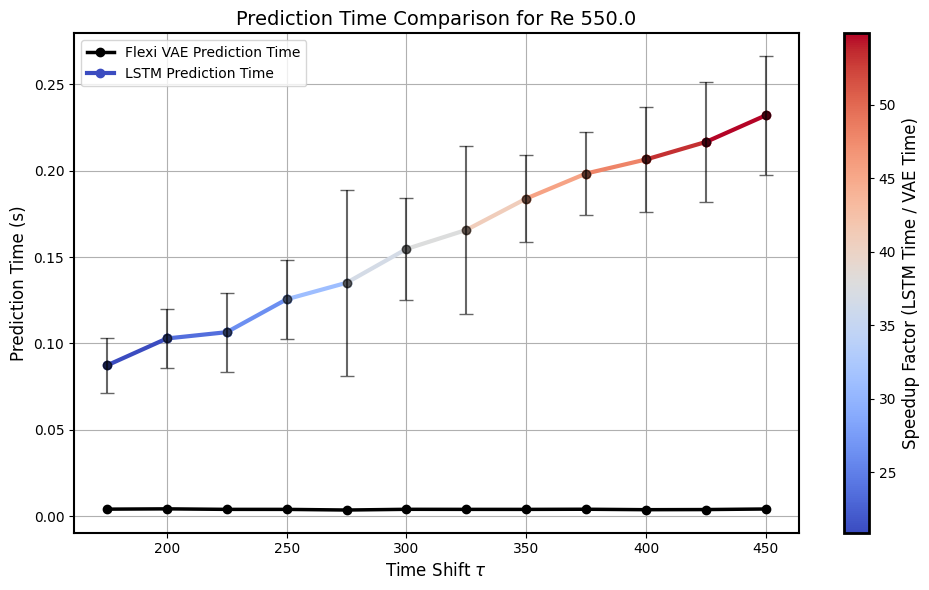

In [30]:
# Compute speedup factor
speedup = [lstm / vae for lstm, vae in zip(lstm_times, vae_times)]

# Normalize speedup for colormap
norm = Normalize(vmin=min(speedup), vmax=max(speedup))
cmap = cm.coolwarm

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Increase axis thickness
ax1.spines['top'].set_linewidth(1.5)
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)

# Plot Flexi VAE prediction times (thicker and black color)
ax1.plot(
    taus, 
    vae_times, 
    '-o', 
    label="Flexi VAE Prediction Time", 
    linewidth=2.5, 
    color='black'
)

# Plot LSTM prediction times with colormap
for i in range(len(taus) - 1):
    ax1.plot(
        taus[i:i+2],
        lstm_times[i:i+2],
        '-o',
        color=cmap(norm(speedup[i])),
        linewidth=3.0,  # Thicker line
        label="LSTM Prediction Time" if i == 0 else ""
    )

# Add variability as vertical black lines with caps
for i in range(len(taus)):
    ax1.errorbar(
        taus[i],
        lstm_times[i],
        yerr=lstm_variability[i],
        fmt='o',
        color='black',
        alpha=0.6,
        capsize=5  # Add horizontal caps at the ends
    )

# Add labels and grid
ax1.set_xlabel(r"Time Shift $\tau$", fontsize=12)
ax1.set_ylabel("Prediction Time (s)", fontsize=12)
ax1.set_title(f"Prediction Time Comparison for Re {Re_value}", fontsize=14)
ax1.grid()
ax1.legend(loc="upper left")

# Add colorbar for speedup
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label("Speedup Factor (LSTM Time / VAE Time)", fontsize=12)

plt.tight_layout()

# Save the figure
#plt.savefig("Speedup_re_2650.png", dpi=300, bbox_inches='tight')

plt.show()

## Replicate for the other two Re and also on GPU! 

# Overall Model Comparisons - Viscous Burgers

In [31]:
from model_v2 import Encoder, Decoder, Propagator_concat as Propagator_C, Propagator_encoding as Propagator_E, Model, loss_function

# Loading paths of all the 6 best models -
# 10K - concat -HDE
ten_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/10k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-02-13-07-47_4bfbb352_best.pt"
ten_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/10k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-02-10-38-46_45631673_best.pt"

# 20k - concat - HDE
twenty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/20k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-01-31-21-15-07_28928994_best.pt"
twenty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/20k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-01-31-19-52-18_d7fb05c6_best.pt"

# 40k - concat - HDE
fourty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/40k_samples/FlexiProp_concat_Burgers/checkpoints/FlexiPropagator_2025-01-30-06-36-01_318b9c89_best.pt"
fourty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/40k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-01-10-43-52_a0a18449_best.pt"

# 80k - concat - HDE
eighty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/80k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-01-10-28-34_3e9656b5_best.pt"
eighty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/80k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-01-04-31-51_431b6c0b_best.pt"

# 120k - concat - HDE
hundred_twenty_K_concat_model_path = "/home/krafiq/Desktop/Flexi Propagator 1D/120k_samples/FlexiProp_Concat_Burgers/checkpoints/FlexiPropagator_2025-02-04-09-56-49_0ed23064_best.pt"
hundred_twenty_K_HDE_model_path    = "/home/krafiq/Desktop/Flexi Propagator 1D/120k_samples/FlexiProp_HDE_Burgers/checkpoints/FlexiPropagator_2025-02-03-15-24-27_53cc66c1_best.pt"


def get_model(input_dim, latent_dim, Propagator):
    # Instantiate encoder, decoder, and model
    encoder = Encoder(input_dim, latent_dim)
    decoder = Decoder(latent_dim, input_dim)  # Decoder for x(t)
    propagator = Propagator(latent_dim)  # z(t) --> z(t+tau)
    model = Model(encoder, decoder, propagator)
    return model

def load_model_weights(model, checkpoint_path):
    """
    Loads the checkpoint from the given path, extracts the model_state_dict
    (if it exists), and loads it into the model using strict=False.
    """
    if not os.path.isfile(checkpoint_path):
        print(f"Checkpoint file not found at path: {checkpoint_path}")
        return model
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    except Exception as e:
        print(f"Error loading checkpoint from {checkpoint_path}: {e}")
        return model
    
    # If the checkpoint has a key "model_state_dict", extract it.
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Instantiate the template models (not used for loading but can serve as a reference)
concat_model_template = get_model(128, 2, Propagator_C)
HDE_model_template    = get_model(128, 2, Propagator_E)

# 10k models
ten_K_concat_model = get_model(128, 2, Propagator_C)
ten_K_concat_model = load_model_weights(ten_K_concat_model, ten_K_concat_model_path)

ten_K_HDE_model = get_model(128, 2, Propagator_E)
ten_K_HDE_model = load_model_weights(ten_K_HDE_model, ten_K_HDE_model_path)

# 20k models
twenty_K_concat_model = get_model(128, 2, Propagator_C)
twenty_K_concat_model = load_model_weights(twenty_K_concat_model, twenty_K_concat_model_path)

twenty_K_HDE_model = get_model(128, 2, Propagator_E)
twenty_K_HDE_model = load_model_weights(twenty_K_HDE_model, twenty_K_HDE_model_path)

# 40k models
fourty_K_concat_model = get_model(128, 2, Propagator_C)
fourty_K_concat_model = load_model_weights(fourty_K_concat_model, fourty_K_concat_model_path)

fourty_K_HDE_model = get_model(128, 2, Propagator_E)
fourty_K_HDE_model = load_model_weights(fourty_K_HDE_model, fourty_K_HDE_model_path)

# 80k models
eighty_K_concat_model = get_model(128, 2, Propagator_C)
eighty_K_concat_model = load_model_weights(eighty_K_concat_model, eighty_K_concat_model_path)

eighty_K_HDE_model = get_model(128, 2, Propagator_E)
eighty_K_HDE_model = load_model_weights(eighty_K_HDE_model, eighty_K_HDE_model_path)

# 120k models
hundred_twenty_K_concat_model = get_model(128, 2, Propagator_C)
hundred_twenty_K_concat_model = load_model_weights(hundred_twenty_K_concat_model, hundred_twenty_K_concat_model_path)

hundred_twenty_K_HDE_model = get_model(128, 2, Propagator_E)
hundred_twenty_K_HDE_model = load_model_weights(hundred_twenty_K_HDE_model, hundred_twenty_K_HDE_model_path)


# loading the intervals - 
data_path = "./data"
_, _, re_interval_split, tau_interval_split = load_from_path(data_path)

# Interval Split
print("Re Interval Split", re_interval_split)
print()
print("Tau Interval Split", tau_interval_split)

Re Interval Split IntervalSplit(interpolation=[822.0727212912974, 1022.0727212912974], extrapolation_left=[400, 600.0], extrapolation_right=[2200.0, 2400])

Tau Interval Split IntervalSplit(interpolation=[340.3940583106784, 367.8940583106784], extrapolation_left=[150, 177.5], extrapolation_right=[397.5, 425])


In [32]:
# --- EXPERIMENT PARAMETERS ---
num_samples = 3000      # Number of random (Re, tau) combinations to test
dt = 2.0 / 500.0        # Time step scale factor
t0_list = [0.20, 0.40, 0.60, 0.80, 1.0, 1.25, 1.5]  # List of initial times to average over

# Prepare lists to store MSE errors for each model:
errors_10k_concat = []
errors_20k_concat = []
errors_40k_concat = []
errors_80k_concat = []
errors_120k_concat = []

errors_10k_HDE    = []
errors_20k_HDE    = []
errors_40k_HDE    = []
errors_80k_HDE    = []
errors_120k_HDE    = []

# --- LOOP OVER RANDOM SAMPLES ---
for i in tqdm(range(num_samples), desc ="Sampling Status"):
    # Randomly choose the extrapolation zone for Re and tau
    re_zone  = np.random.choice(["extrapolation_left", "extrapolation_right"])
    tau_zone = np.random.choice(["extrapolation_left", "extrapolation_right"])
    
    # Use getattr to fetch the corresponding interval from the split objects
    Re_value = np.random.uniform(*getattr(re_interval_split, re_zone))
    tau_val  = np.random.uniform(*getattr(tau_interval_split, tau_zone))
    
    # We'll accumulate error over the different t0 values for this (Re, tau) pair:
    err_10k_concat_sample = 0
    err_20k_concat_sample = 0
    err_40k_concat_sample = 0
    err_80k_concat_sample = 0
    err_120k_concat_sample = 0

    err_4k_HDE_sample    = 0
    err_10k_HDE_sample    = 0
    err_20k_HDE_sample    = 0
    err_40k_HDE_sample    = 0
    err_80k_HDE_sample    = 0
    err_120k_HDE_sample    = 0
    
    for t0 in t0_list:
        # --- Compute the initial and exact final state for this t0 ---
        x_t = exact_solution(Re_value, t0)           # Initial state (x_t)
        t_final = t0 + tau_val * dt                   # Final time corresponding to the sampled tau
        x_exact = exact_solution(Re_value, t_final)    # Exact final state

        # --- Convert inputs to torch tensors ---
        xt = torch.tensor([x_t]).float()[:, None]      # Shape: (1, 128)
        tau_tensor = torch.tensor([tau_val]).float()[:, None]  # Shape: (1, 1)
        Re_tensor  = torch.tensor([Re_value]).float()[:, None] # Shape: (1, 1)
        
        # --- Run each model to predict the future state ---
        with torch.no_grad():
            # For the 20k Concat model:
            _, x_hat_tau_10k_concat, _, _, _ = ten_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 20k Concat model:
            _, x_hat_tau_20k_concat, _, _, _ = twenty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 40k Concat model:
            _, x_hat_tau_40k_concat, _, _, _ = fourty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 80k Concat model:
            _, x_hat_tau_80k_concat, _, _, _ = eighty_K_concat_model(xt, tau_tensor, Re_tensor)
            # For the 120k Concat model:
            _, x_hat_tau_120k_concat, _, _, _ = hundred_twenty_K_concat_model(xt, tau_tensor, Re_tensor)

            # For the 10k HDE model:
            _, x_hat_tau_10k_HDE, _, _, _ = ten_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 20k HDE model:
            _, x_hat_tau_20k_HDE, _, _, _ = twenty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 40k HDE model:
            _, x_hat_tau_40k_HDE, _, _, _ = fourty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 80k HDE model:
            _, x_hat_tau_80k_HDE, _, _, _ = eighty_K_HDE_model(xt, tau_tensor, Re_tensor)
            # For the 120k HDE model:
            _, x_hat_tau_120k_HDE, _, _, _ = hundred_twenty_K_HDE_model(xt, tau_tensor, Re_tensor)
        
        # --- Compute MSE for each model for this t0 ---
        mse_10k_concat = np.mean((x_hat_tau_10k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_20k_concat = np.mean((x_hat_tau_20k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_40k_concat = np.mean((x_hat_tau_40k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_80k_concat = np.mean((x_hat_tau_80k_concat.squeeze().cpu().numpy() - x_exact)**2)
        mse_120k_concat = np.mean((x_hat_tau_120k_concat.squeeze().cpu().numpy() - x_exact)**2)

        mse_10k_HDE    = np.mean((x_hat_tau_10k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_20k_HDE    = np.mean((x_hat_tau_20k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_40k_HDE    = np.mean((x_hat_tau_40k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_80k_HDE    = np.mean((x_hat_tau_80k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        mse_120k_HDE    = np.mean((x_hat_tau_120k_HDE.squeeze().cpu().numpy()    - x_exact)**2)
        
        # Accumulate the error over t0 values
        err_10k_concat_sample += mse_10k_concat
        err_20k_concat_sample += mse_20k_concat
        err_40k_concat_sample += mse_40k_concat
        err_80k_concat_sample += mse_80k_concat
        err_120k_concat_sample += mse_120k_concat

        err_10k_HDE_sample    += mse_10k_HDE
        err_20k_HDE_sample    += mse_20k_HDE
        err_40k_HDE_sample    += mse_40k_HDE
        err_80k_HDE_sample    += mse_80k_HDE
        err_120k_HDE_sample    += mse_120k_HDE

    # Average the error for this sample over the different t0 values
    num_t0 = len(t0_list)
    errors_10k_concat.append(err_10k_concat_sample / num_t0)
    errors_20k_concat.append(err_20k_concat_sample / num_t0)
    errors_40k_concat.append(err_40k_concat_sample / num_t0)
    errors_80k_concat.append(err_80k_concat_sample / num_t0)
    errors_120k_concat.append(err_120k_concat_sample / num_t0)

    errors_10k_HDE.append(err_10k_HDE_sample / num_t0)
    errors_20k_HDE.append(err_20k_HDE_sample / num_t0)
    errors_40k_HDE.append(err_40k_HDE_sample / num_t0)
    errors_80k_HDE.append(err_80k_HDE_sample / num_t0)
    errors_120k_HDE.append(err_120k_HDE_sample / num_t0)

# --- Compute Average MSE for Each Model Over All Samples ---
avg_10k_concat = np.mean(errors_10k_concat)
avg_20k_concat = np.mean(errors_20k_concat)
avg_40k_concat = np.mean(errors_40k_concat)
avg_80k_concat = np.mean(errors_80k_concat)
avg_120k_concat = np.mean(errors_120k_concat)

avg_10k_HDE    = np.mean(errors_10k_HDE)
avg_20k_HDE    = np.mean(errors_20k_HDE)
avg_40k_HDE    = np.mean(errors_40k_HDE)
avg_80k_HDE    = np.mean(errors_80k_HDE)
avg_120k_HDE    = np.mean(errors_120k_HDE)

print("Average MSE Errors over {} samples (averaged over t0 values):".format(num_samples))
print(f"10k Concat: {avg_10k_concat:.4e}")
print(f"20k Concat: {avg_20k_concat:.4e}")
print(f"40k Concat: {avg_40k_concat:.4e}")
print(f"80k Concat: {avg_80k_concat:.4e}")
print(f"120k Concat: {avg_120k_concat:.4e}")

print(f"10k HDE:    {avg_10k_HDE:.4e}")
print(f"20k HDE:    {avg_20k_HDE:.4e}")
print(f"40k HDE:    {avg_40k_HDE:.4e}")
print(f"80k HDE:    {avg_80k_HDE:.4e}")
print(f"120k HDE:    {avg_120k_HDE:.4e}")

# --- Plotting the Results ---
# Define the sample size points (in thousands)
sample_sizes = [10, 20, 40, 80, 120]

# Prepare the average errors for plotting:
avg_concat = [avg_10k_concat, avg_20k_concat, avg_40k_concat, avg_80k_concat, avg_120k_concat]
avg_HDE    = [avg_10k_HDE, avg_20k_HDE, avg_40k_HDE, avg_80k_HDE, avg_120k_HDE]

Sampling Status: 100%|██████████████████████████████████████████████████| 3000/3000 [14:06<00:00,  3.54it/s]

Average MSE Errors over 3000 samples (averaged over t0 values):
10k Concat: 1.4343e-04
20k Concat: 1.0899e-04
40k Concat: 6.9542e-05
80k Concat: 3.7798e-05
120k Concat: 7.9735e-05
10k HDE:    6.6155e-04
20k HDE:    4.8663e-04
40k HDE:    7.6634e-04
80k HDE:    5.9629e-04
120k HDE:    7.4533e-04


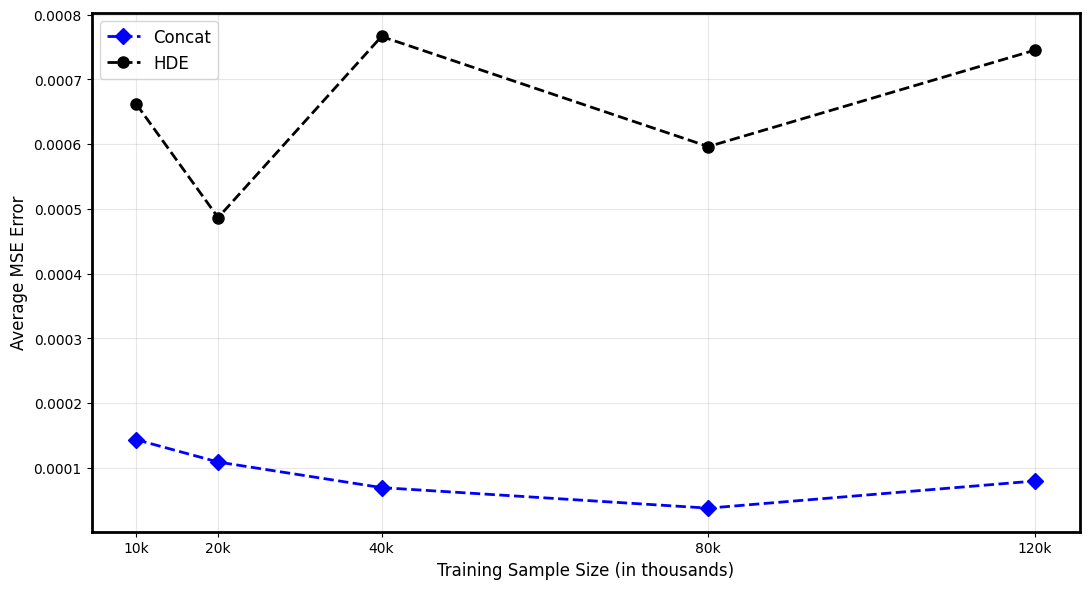

In [33]:
plt.figure(figsize=(11, 6))
# Plot for Concat models
plt.plot(sample_sizes, avg_concat, marker='D', color = "Blue", linestyle='--', linewidth=2, markersize=8, label='Concat')
# Plot for HDE models
plt.plot(sample_sizes, avg_HDE, marker='o', color = "Black",  linestyle='--', linewidth=2, markersize=8, label='HDE')

plt.xlabel("Training Sample Size (in thousands)", fontsize=12)
plt.ylabel("Average MSE Error", fontsize=12)
#plt.title("Average MSE Error vs. Training Sample Size ({} Random Samples)".format(num_samples), fontsize=14)
plt.xticks(sample_sizes, [f"{s}k" for s in sample_sizes])
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
#plt.savefig("concat_VS_HDE")
plt.show()

### Physical Intrepretability of Parametric propagated latent

In [34]:
# Parameters
TRANGE = (0, 2)
Re_value = torch.tensor([2200], dtype=torch.float32)  # Interpolation Re value
t0 = 0.10  # Initial time
dt = 2.0 / 500.0
taus = torch.arange(175, 425, dtype=torch.float32).unsqueeze(-1)  # Shape: (250, 1)

# Generate initial state x_t
x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)

In [35]:
# # Define five different Reynolds numbers (now 9 to match your Re_values)

# Re_values = torch.tensor([500, 900, 1300, 1700, 2100, 2300], dtype=torch.float32)

# # Expand markers and colors to match 9 Re_values
# markers = ['o', 's', '^', 'D', 'P', '*']  # 6 distinct markers
# colors = plt.cm.tab10(np.linspace(0, 1, 6))  # 9 distinct colors from colormap

# # Create figure with 2 subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# cmap = plt.get_cmap('jet')

# # Process both models
# for ax, model, model_name in [(ax1, hundred_twenty_K_concat_model, "Concatenation Model"), 
#                               (ax2, hundred_twenty_K_HDE_model, "HDE Model")]:
    
#     for i, Re_value in enumerate(Re_values):
#         x_t = torch.tensor(exact_solution(Re_value.item(), t0)[None, None, :], dtype=torch.float32)

#         # Lists to store results for current Re and model
#         z_taus = []
        
#         # Propagate latents
#         for tau in taus:
#             with torch.no_grad():
#                 _, x_hat_tau, mean, log_var, z_tau = model(
#                     x_t, 
#                     tau.view(1, 1), 
#                     Re_value.view(1, 1)
#                 )
#             z_taus.append(z_tau.squeeze(0))

#         # Compute physical times and get exact solutions
#         physical_times = t0 + taus.squeeze(-1).numpy() * dt
#         exact_solns = torch.stack([
#             torch.tensor(exact_solution(Re_value.item(), t), dtype=torch.float32) 
#             for t in physical_times
#         ])
        
#         # Get latents from exact solutions
#         with torch.no_grad():
#             means_from_exact = torch.stack([
#                 model.encoder(exact_sol.unsqueeze(0).unsqueeze(0))[0].squeeze(0)
#                 for exact_sol in exact_solns
#             ])

#         # Convert to numpy arrays
#         actual_means = means_from_exact.numpy().squeeze()
#         propagated_means = torch.stack(z_taus).numpy().squeeze()
        
#         # Plotting with unique markers/colors for each Re
#         ax.scatter(
#             actual_means[:, 0], actual_means[:, 1],
#             color=colors[i], 
#             marker=markers[i],
#             label=f'Actual (Re={Re_value.item()})', 
#             alpha=0.7,
#             s=40  # Increased marker size
#         )
        
#         sc = ax.scatter(
#             propagated_means[:, 0], propagated_means[:, 1],
#             c=taus.numpy().squeeze(), 
#             cmap=cmap, 
#             marker=markers[i],
#             edgecolor=colors[i],
#             linewidth=0.5,
#             alpha=0.7,
#             label=f'Propagated (Re={Re_value.item()})'
#         )

#     # Formatting
#     ax.set_title(model_name, fontsize=16)
#     ax.set_xlabel(r'$Z_1$', fontsize=14)
#     ax.set_ylabel(r'$Z_2$', fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.grid(alpha=0.3)
    
#     # Add colorbar
#     cbar = fig.colorbar(sc, ax=ax)
#     cbar.set_label('Tau alues', fontsize=12)
    
#     # Improved legend
#     ax.legend(fontsize=9, loc='upper right', ncol=2)

# # Final formatting
# plt.suptitle("Latent Space Comparison Across Reynolds Numbers", fontsize=18, y=1.02)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)  # Add space between subplots
# plt.show()

#### 10K Model - Concat Vs HDE

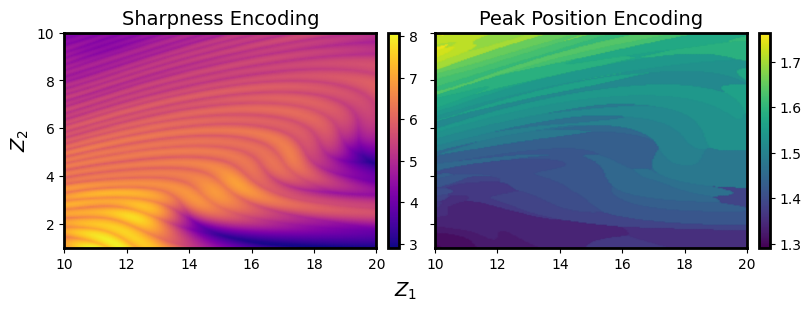

In [36]:
# Define the latent space sampling grid
z1_vals = np.linspace(10, 20, 200)
z2_vals = np.linspace(1, 10, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = ten_K_concat_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)
#plt.savefig("10K_Concat")
plt.show()


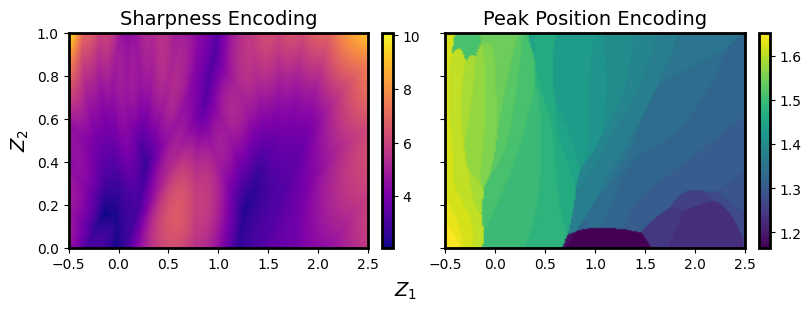

In [37]:
# Define the latent space sampling grid
z1_vals = np.linspace(-0.5, 2.5, 200)
z2_vals = np.linspace(0, 1, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = ten_K_HDE_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("10K_HDE")
plt.show()


#### 20K Model - Concat Vs HDE

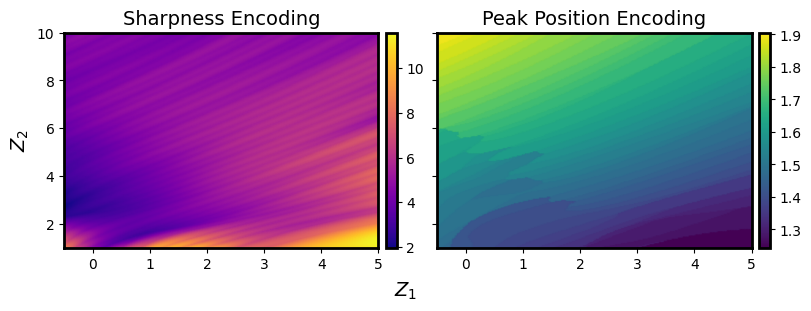

In [38]:
# Define the latent space sampling grid
z1_vals = np.linspace(-0.5, 5, 200)
z2_vals = np.linspace(1, 10, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = twenty_K_concat_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("20K_Concat")
plt.show()


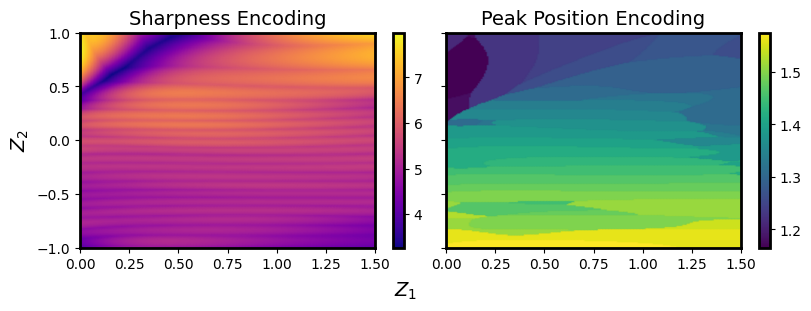

In [39]:
# Define the latent space sampling grid
z1_vals = np.linspace(0, 1.5, 200)
z2_vals = np.linspace(-1, 1, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = twenty_K_HDE_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("20K_HDE")
plt.show()


### 40K Models

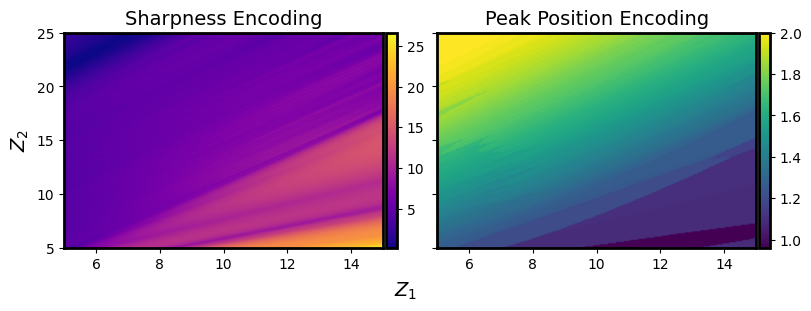

In [40]:
# Define the latent space sampling grid
z1_vals = np.linspace(5, 15, 200)
z2_vals = np.linspace(5, 25, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = fourty_K_concat_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("40K_Concat")
plt.show()


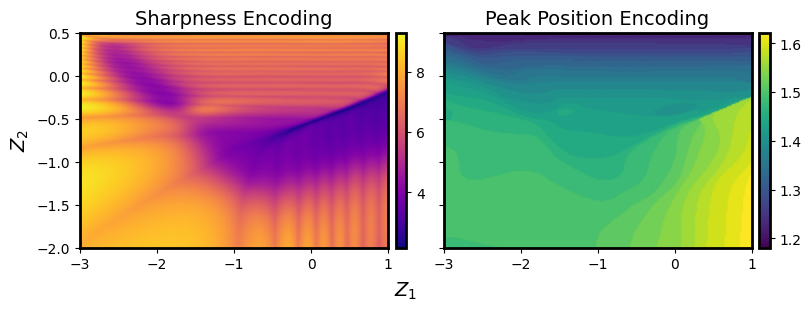

In [41]:
# Define the latent space sampling grid
z1_vals = np.linspace(-3, 1, 200)
z2_vals = np.linspace(-2, 0.5, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = fourty_K_HDE_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("40K_HDE")
plt.show()


### 80K Models

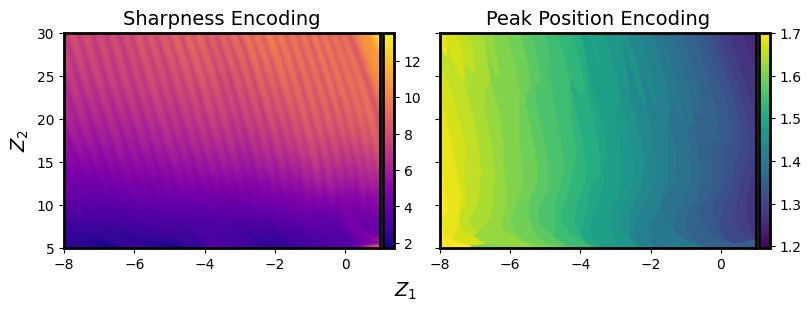

In [42]:
# Define the latent space sampling grid
z1_vals = np.linspace(-8, 1, 200)
z2_vals = np.linspace(5, 30, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = eighty_K_concat_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("80K_Concat")
plt.show()

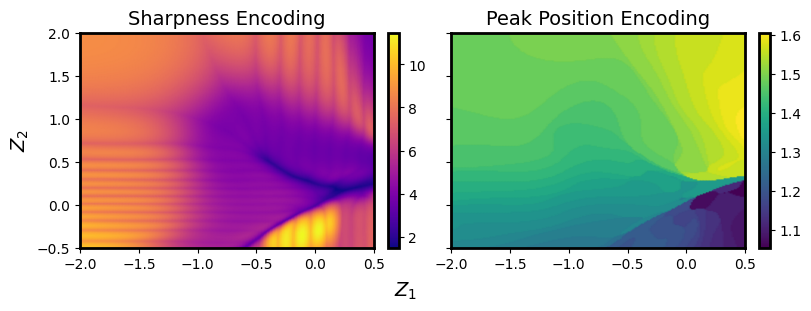

In [43]:
# Define the latent space sampling grid
z1_vals = np.linspace(-2, 0.5, 200)
z2_vals = np.linspace(-0.5, 2, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = eighty_K_HDE_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("80K_HDE")
plt.show()


### 120K models

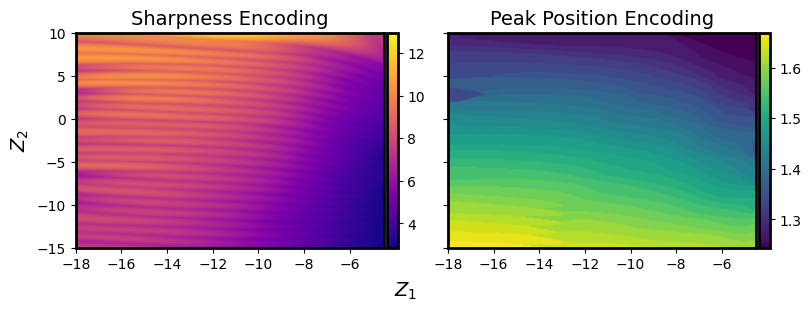

In [44]:
# Define the latent space sampling grid
z1_vals = np.linspace(-18, -4.5, 200)
z2_vals = np.linspace(-15, 10, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (400, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = hundred_twenty_K_concat_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("120K_Concat")
plt.show()


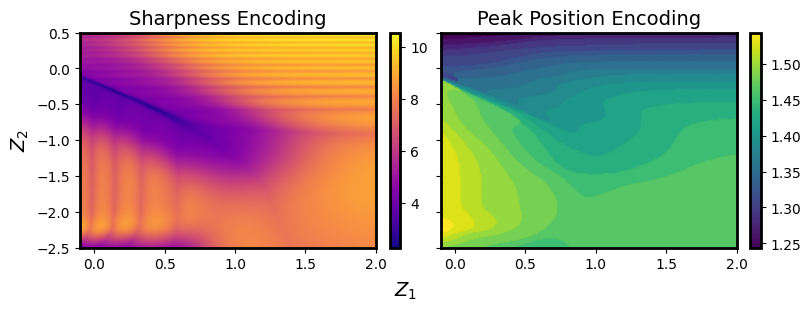

In [45]:
# Define the latent space sampling grid
z1_vals = np.linspace(-0.1, 2, 200)
z2_vals = np.linspace(-2.5, 0.5, 200)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)  # Create a 2D meshgrid
latent_grid = np.stack([Z1.ravel(), Z2.ravel()], axis=1)  # Shape: (2500, 2)

# Convert to tensor for decoding
latent_tensors = torch.tensor(latent_grid, dtype=torch.float32)

# Decode the latent vectors
with torch.no_grad():
    decoded_signals = hundred_twenty_K_HDE_model.decoder(latent_tensors)

# Compute sharpness and peak location
sharpness = []
peak_positions = []

x_vals = np.linspace(0, 2, decoded_signals.shape[1])
dx = x_vals[1] - x_vals[0]

for signal in decoded_signals.numpy():
    grad_u = np.gradient(signal, dx)  # Compute spatial gradient
    sharpness.append(np.max(np.abs(grad_u)))  # Max gradient as sharpness metric
    peak_positions.append(x_vals[np.argmax(signal)])  # Index where max occurs

sharpness = np.array(sharpness).reshape(Z1.shape)
peak_positions = np.array(peak_positions).reshape(Z1.shape)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, gridspec_kw={'wspace': 0})  # No space between plots

# Sharpness Plot (Left)
c1 = axes[0].pcolormesh(Z1, Z2, sharpness, cmap='plasma', shading='gouraud')
axes[0].set_ylabel("$Z_2$", fontsize=14)
axes[0].set_title("Sharpness Encoding", fontsize=14)

# Peak Position Plot (Right)
c2 = axes[1].pcolormesh(Z1, Z2, peak_positions, cmap='viridis', shading='gouraud')
axes[1].set_title("Peak Position Encoding", fontsize=14)

# Remove redundant y-axis labels on the second plot for better aesthetics
axes[1].set_yticklabels([])

# Set a single x-axis label centered below both plots
fig.supxlabel("$Z_1$", fontsize=14)

# Move colorbar for sharpness encoding to **right of the first plot**
cbar1 = fig.colorbar(c1, ax=axes[0], location="right", fraction=0.04, pad=0.01)
cbar2 = fig.colorbar(c2, ax=axes[1], location="right", fraction=0.04, pad=0.01)

#plt.savefig("120K_HDE")
plt.show()
